In [17]:
import numpy as np
import scipy.linalg
import itertools

# Function to generate a random graph
def generate_random_graph(n):
    """
    Generate a random graph with n vertices.
    Each edge has a probability of 1/2 of being included.

    Parameters:
        n (int): Number of vertices in the graph.

    Returns:
        np.ndarray: Adjacency matrix of the random graph.
    """
    adjacency_matrix = np.random.randint(0, 2, size=(n, n))
    np.fill_diagonal(adjacency_matrix, 0)  # No self-loops
    adjacency_matrix = np.triu(adjacency_matrix, 1)
    adjacency_matrix += adjacency_matrix.T
    return adjacency_matrix

# Function to construct the initial Hamiltonian H_B
def construct_initial_hamiltonian(n, k):
    """
    Construct the initial Hamiltonian H_B to promote a uniform superposition over subsets of size k.

    Parameters:
        n (int): Number of vertices.
        k (int): Size of the subset to find.

    Returns:
        np.ndarray: Initial Hamiltonian matrix.
    """
    dim = 2 ** n  # Full computational basis size
    H_B = np.zeros((dim, dim))

    # Populate H_B to promote transitions to states with Hamming weight k
    for i in range(dim):
        binary = f"{i:0{n}b}"
        hamming_weight = binary.count("1")
        if hamming_weight == k:
            for j in range(dim):
                if i != j:
                    binary_j = f"{j:0{n}b}"
                    if binary_j.count("1") == k:
                        H_B[i, j] = 1

    return -H_B  # Negate to ensure the ground state has minimum energy

# Function to construct the problem Hamiltonian H_P
def construct_problem_hamiltonian(graph, k):
    """
    Construct the problem Hamiltonian H_P.

    Parameters:
        graph (np.ndarray): Adjacency matrix of the graph.
        k (int): Size of the subset to find.

    Returns:
        np.ndarray: Problem Hamiltonian matrix.
    """
    n = graph.shape[0]
    dim = 2 ** n  # Full computational basis size
    H_P = np.zeros((dim, dim))

    for i in range(dim):
        binary = f"{i:0{n}b}"
        hamming_weight = binary.count("1")
        if hamming_weight == k:
            for u, v in itertools.combinations(range(n), 2):
                if binary[u] == "1" and binary[v] == "1" and graph[u, v] == 0:
                    H_P[i, i] += 1  # Penalize non-cliques
        else:
            H_P[i, i] += 1  # Penalize states with incorrect Hamming weight

    return H_P

# Function to prepare the initial state

def prepare_initial_state(n, k):
    """
    Prepare the initial state as a uniform superposition over states with Hamming weight k.

    Parameters:
        n (int): Number of vertices.
        k (int): Target Hamming weight.

    Returns:
        np.ndarray: Initial state vector.
    """
    dim = 2 ** n
    psi = np.zeros(dim, dtype=complex)
    for i in range(dim):
        binary = f"{i:0{n}b}"
        if binary.count("1") == k:
            psi[i] = 1
    norm = np.linalg.norm(psi)
    return psi / norm

# Function to simulate quantum evolution
def simulate_adiabatic_evolution(H_B, H_P, T, steps, initial_state):
    """
    Simulate the adiabatic quantum evolution.

    Parameters:
        H_B (np.ndarray): Initial Hamiltonian.
        H_P (np.ndarray): Problem Hamiltonian.
        T (float): Total evolution time.
        steps (int): Number of time steps.
        initial_state (np.ndarray): Initial state vector.

    Returns:
        np.ndarray: Final state vector.
    """
    psi = initial_state
    dt = T / steps

    for step in range(steps):
        t = step * dt
        s = t / T
        H_t = (1 - s) * H_B + s * H_P
        U_t = scipy.linalg.expm(-1j * H_t * dt)
        psi = U_t @ psi

    return psi

# Function to find the largest clique
    
#     return max_cliques
def find_all_largest_cliques(graph):
    n = graph.shape[0]
    
    # Start from the largest possible clique size and go down
    for size in range(n, 0, -1):
        max_cliques = []
        for vertices in itertools.combinations(range(n), size):
            if is_clique(graph, vertices):
                max_cliques.append(vertices)

        # If we found at least one clique of this size, return it
        if max_cliques:
            return max_cliques
    
    return []  # If no cliques were found (shouldn't happen)


# Function to check if a set of vertices forms a clique
def is_clique(graph, vertices):
    """
    Check if a given set of vertices forms a clique in the graph.

    Parameters:
        graph (np.ndarray): Adjacency matrix of the graph.
        vertices (list): List of vertex indices.

    Returns:
        bool: True if the vertices form a clique, False otherwise.
    """
    for i, j in itertools.combinations(vertices, 2):
        if graph[i, j] == 0:
            return False
    return True


In [18]:
# Static adjacency matrix
# graph = np.array([
#     [0, 0, 1, 1, 0, 0],
#     [0, 0, 1, 0, 1, 1],
#     [1, 1, 0, 0, 1, 1],
#     [1, 0, 0, 0, 0, 1],
#     [0, 1, 1, 0, 0, 0],
#     [0, 1, 1, 1, 0, 0]
# ])

graph = generate_random_graph(6)

# Main execution
if __name__ == "__main__":
    n = graph.shape[0]
    k = int(2 * np.log2(n))
    T = 10
    steps = 100
    
    print("n = ", n)
    print("Initial k = ", k)
    print("Adjacency Matrix:")
    print(graph)

    # Classical largest cliques
    largest_cliques = find_all_largest_cliques(graph)
    print("\nAll Largest Cliques (Classical):", largest_cliques)

    # Iterate to match quantum and classical results
    while k > 0:
        print("\nTrying k =", k)

        # Construct Hamiltonians
        H_B = construct_initial_hamiltonian(n, k)
        H_P = construct_problem_hamiltonian(graph, k)

        # Prepare initial state
        initial_state = prepare_initial_state(n, k)

        # Simulate adiabatic evolution
        final_state = simulate_adiabatic_evolution(H_B, H_P, T, steps, initial_state)

        # Interpret quantum result
        max_amplitude_index = np.argmax(np.abs(final_state))
        binary_representation = f"{max_amplitude_index:0{n}b}"
        clique_vertices = [i for i, bit in enumerate(binary_representation) if bit == '1']
        print("Quantum Largest Clique:", clique_vertices)

        # Check if quantum result matches any of the largest cliques
        if any(set(clique_vertices) == set(clique) for clique in largest_cliques):
            print("\nMatch found! k =", k)
            break
        else:
            print("No match. Reducing k.")
            k -= 1


n =  6
Initial k =  5
Adjacency Matrix:
[[0 0 1 1 0 0]
 [0 0 1 1 1 1]
 [1 1 0 0 0 1]
 [1 1 0 0 0 0]
 [0 1 0 0 0 1]
 [0 1 1 0 1 0]]

All Largest Cliques (Classical): [(1, 2, 5), (1, 4, 5)]

Trying k = 5
Quantum Largest Clique: [0, 1, 2, 3, 5]
No match. Reducing k.

Trying k = 4
Quantum Largest Clique: [1, 2, 4, 5]
No match. Reducing k.

Trying k = 3
Quantum Largest Clique: [1, 4, 5]

Match found! k = 3


Edges in the graph: [(0, 2), (0, 3), (1, 2), (1, 3), (1, 4), (1, 5), (2, 5), (4, 5)]


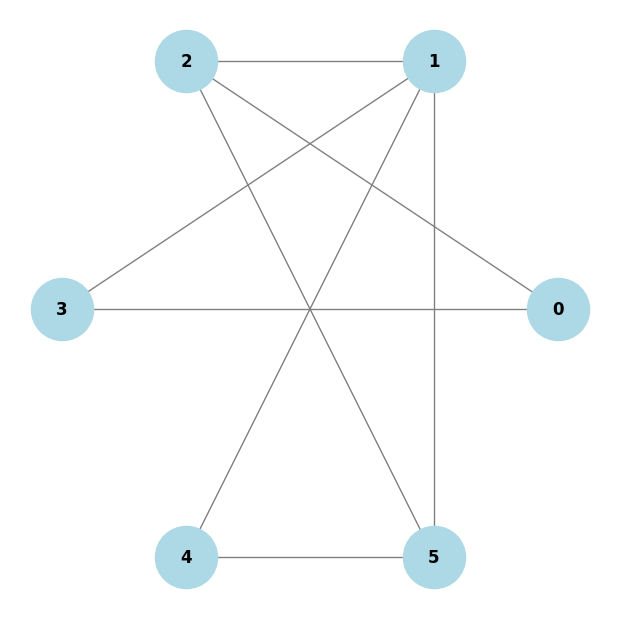

In [19]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

# Create the graph
G = nx.from_numpy_array(graph)

# Print edges to verify correctness
print("Edges in the graph:", list(G.edges))

# Draw the graph
plt.figure(figsize=(6, 6))
pos = nx.circular_layout(G)  # Better visualization
nx.draw(G, pos, with_labels=True, node_color="lightblue", edge_color="gray", node_size=2000, font_size=12, font_weight="bold")

plt.show()
